# Popularity hide and seek
> "A hidden Markov model to estimate latent presidential popularity across time"

- toc: true
- badges: true
- comments: true
- author: Alexandre Andorra, Rémi Louf
- categories: [popularity, Macron, Hidden Markov models, polls]
- image: images/gp-popularity.png

A few months ago, [I experimented with a Gaussian Process](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html) to estimate the popularity of French presidents across time. The experiment was really positive, and helped me get familiar with the beauty of GPs. This time, I teamed up with [Rémi Louf](https://twitter.com/remilouf) on a [hidden Markov model](https://en.wikipedia.org/wiki/Hidden_Markov_model) to estimate the same process -- what is the true latent popularity, that we only observe through the noisy data that are polls?

This was supposed to be a trial run before working on an electoral model for the coming regional elections in France -- it's always easier to start with 2 dimensions than 6, right? But the model turned out to be so good at smoothing and predicting popularity data that we thought it'd be a shame not to share it. And voilà!

## Show me the data!

The data are the same as in [my GP post](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html), so we're not going to spend a lot of time explaining them. It's basically all the popularity opinion polls of French presidents since the term limits switched to 5 years (in 2002).

Let's import those data, as well as the (fabulous) packages we'll need:

In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as aet
from scipy.special import expit as logistic

In [2]:
# hide
RANDOM_SEED = 926
np.random.seed(RANDOM_SEED)
arviz.style.use("arviz-darkgrid")

In [3]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/AlexAndorra/pollsposition_models/master/data/raw_popularity_presidents.csv",
    header=0,
    index_col=0,
    parse_dates=True,
)

In [4]:
# hide
# restrict data to after the switch to 5-year term
data = data.loc[data.index >= pd.to_datetime("2002-05-05")]
data["year"] = data.index.year
data["month"] = data.index.month

data["sondage"] = data["sondage"].replace("Yougov", "YouGov")
data["method"] = data["method"].replace("face-to-face&internet", "face to face")

# convert to proportions
data[["approve_pr", "disapprove_pr"]] = data[["approve_pr", "disapprove_pr"]].copy() / 100
data = data.rename(columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"})

POLLSTERS = data["sondage"].sort_values().unique()
comment = f"""The dataset contains {len(data)} polls between the years {data["year"].min()} and {data["year"].max()}.
There are {len(POLLSTERS)} pollsters: {', '.join(list(POLLSTERS))}
"""
print(comment)

The dataset contains 1083 polls between the years 2002 and 2021.
There are 10 pollsters: BVA, Elabe, Harris, Ifop, Ipsos, Kantar, Odoxa, OpinionWay, Viavoice, YouGov



The number of polls is homogeneous among months, except in the summer because, well, France:

In [6]:
data["month"].value_counts().sort_index()

1     100
2      96
3     100
4      89
5      91
6      95
7      68
8      71
9      94
10     99
11     98
12     82
Name: month, dtype: int64

Let us look at simple stats on the pollsters:

In [10]:
pd.crosstab(data.sondage, data.method, margins=True)

method      face to face  internet  phone  phone&internet   All
sondage                                                        
BVA                    0       101     89               0   190
Elabe                  0        52      0               0    52
Harris                 0        33      0               0    33
Ifop                   0        29    181              38   248
Ipsos                  0        40    177               0   217
Kantar               208         4      0               0   212
Odoxa                  0        67      0               0    67
OpinionWay             0        12      0               0    12
Viavoice               0        20      0               0    20
YouGov                 0        32      0               0    32
All                  208       390    447              38  1083

Interesting: most pollsters only use one method -- internet. Only BVA, Ifop, Ipsos (and Kantar very recently) use different methods. So, if we naively estimate the biases of pollsters and methods individually, we'll get high correlations in our posterior estimates -- the parameter for `face to face` will basically be the one for `Kantar`, and vice versa. So we will need to model the pairs `(pollster, method)` rather than pollsters and methods individually.

Now, let's just plot the raw data and see what they look like:

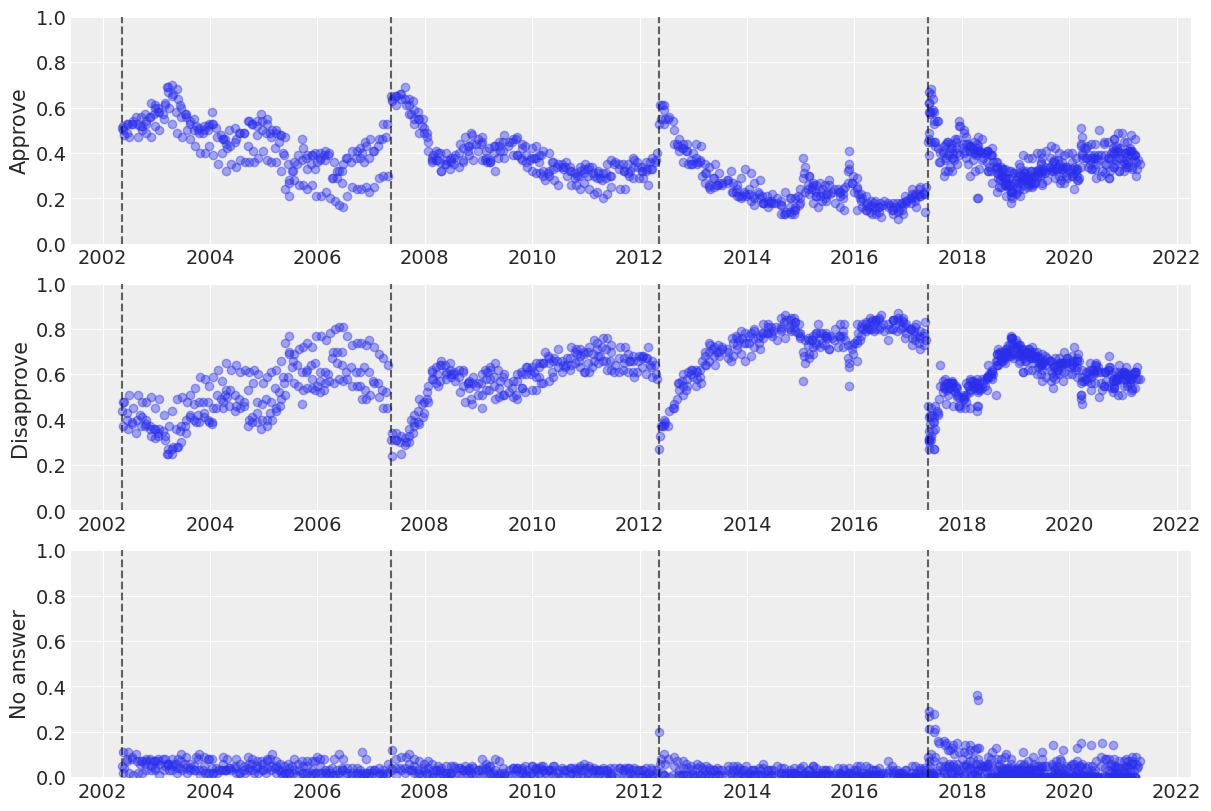

In [15]:
approval_rates = data["p_approve"].values
disapproval_rates = data["p_disapprove"].values
doesnotrespond = 1 - approval_rates - disapproval_rates
newterm_dates = data.reset_index().groupby("president").first()["index"].values
dates = data.index

fig, axes = plt.subplots(3, figsize=(12, 8))
for ax, rate, label in zip(axes.ravel(), [approval_rates, disapproval_rates, doesnotrespond], ["Approve", "Disapprove", "No answer"]):
    ax.plot(dates, rate, "o", alpha=0.4)
    ax.set_ylim(0, 1)
    ax.set_ylabel(label)
    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.6, linestyle="--")

We notice two things when looking at these plots:

1. Approval rates systematically decrease as the goes on.
2. While that's true, some events seem to push the approval rate back up, even though temporarily. This happened in every term, actually. Can that variance really be explained solely with a random walk?
3. Non-response rate is higher during Macron's term.

## Monthly standard deviation

Something that often proves challenging with count data is that they are often more dispersed than traditional models expect them to be. Let's check this now, by computing the monthly standard deviation of the approval rates (we weigh each poll equally, even though we probably should weigh them according to their respective sample size):

In [16]:
rolling_std = (
    data.reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "p_approve"]]
)
rolling_std

year  month  p_approve
0    2002      5   0.017078
1    2002      6   0.030000
2    2002      7   0.005774
3    2002      8   0.045826
4    2002      9   0.025166
..    ...    ...        ...
223  2020     12   0.064627
224  2021      1   0.042661
225  2021      2   0.041748
226  2021      3   0.042980
227  2021      4   0.020000

[228 rows x 3 columns]

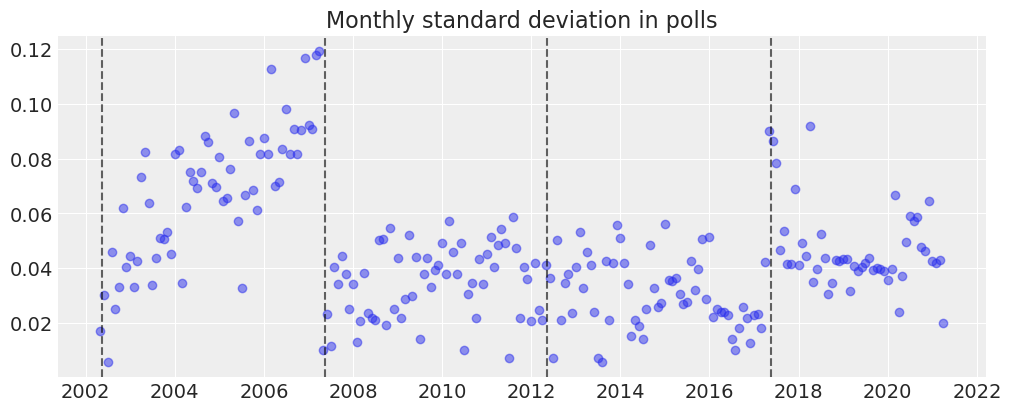

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(pd.to_datetime([f'{y}-{m}-01' for y, m in zip(rolling_std.year, rolling_std.month)]), rolling_std.p_approve.values, "o", alpha=0.5)
ax.set_title("Monthly standard deviation in polls")
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.6, linestyle="--")

There is a very high variance for Chirac's second term, and for the beggining of Macron's term. For Chirac's term, it seems like the difference stems from the polling method: face-to-face approval rates seem to be much lower. For Macron, this high variance is quite hard to explain. In any case, we'll probably have to take this overdispersion (as it's called in statistical linguo) of the data in our models...

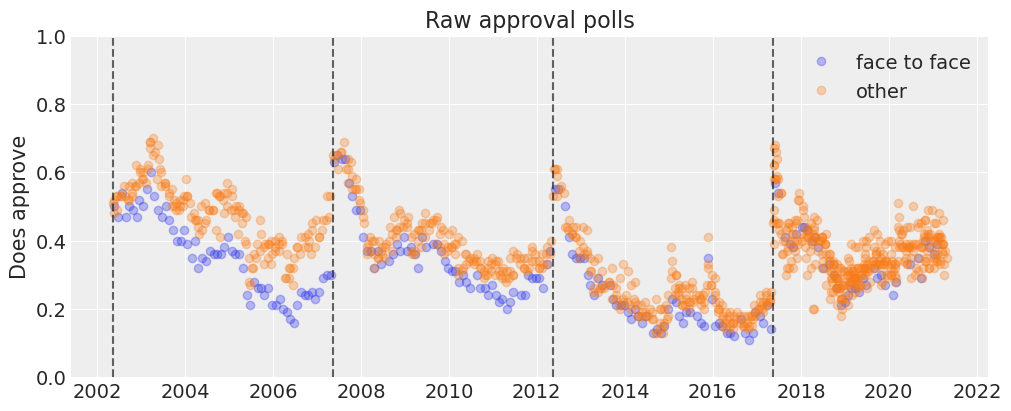

In [23]:
face = data[data["method"] == "face to face"]
dates_face = face.index

other = data[data["method"] != "face to face"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_face, face["p_approve"].values, "o", alpha=0.3, label="face to face")
ax.plot(dates_other, other["p_approve"].values, "o", alpha=0.3, label="other")
ax.set_ylim(0, 1)
ax.set_ylabel("Does approve")
ax.set_title("Raw approval polls")
ax.legend()
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.6, linestyle="--")

## A raw analysis of bias

As each pollster uses different methods to establish and question their samples each month, we don't expect their results to be identical -- _that_ would be troubling. Instead we expect each pollster and each polling method to be at a different place on the spectrum: some report popularity rates in line with the market average, some are below average, some are above.

The model will be able to estimate this bias on the fly and more seriously (if we tell it to), but let's take a look at a crude estimation ourselves, to get a first idea. Note that we're talking about _statistical_ bias here, not _political_ bias: it's very probable that reaching out to people only by internet or phone can have a [selection effect](https://en.wikipedia.org/wiki/Selection_bias) on your sample, without it being politically motivated -- statistics are just hard and stubborn you know 🤷‍♂️

To investigate bias, we now compute the monthly mean of the $p_{approve}$ values and check how each individual poll strayed from this mean:

In [24]:
data = (
    data.reset_index()
    .merge(
        data.groupby(["year", "month"])["p_approve"].mean().reset_index(),
        on=["year", "month"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)
data["diff_approval"] = data["p_approve"] - data["p_approve_mean"]
data.round(2)

field_date president sondage  samplesize        method  p_approve  \
0    2002-05-15   chirac2    Ifop         924         phone       0.51   
1    2002-05-20   chirac2  Kantar         972  face to face       0.50   
2    2002-05-23   chirac2     BVA        1054         phone       0.52   
3    2002-05-26   chirac2   Ipsos         907         phone       0.48   
4    2002-06-16   chirac2    Ifop         974         phone       0.49   
...         ...       ...     ...         ...           ...        ...   
1078 2021-03-29    macron  Kantar        1000      internet       0.36   
1079 2021-03-30    macron  YouGov        1068      internet       0.30   
1080 2021-04-07    macron   Elabe        1003      internet       0.33   
1081 2021-04-10    macron   Ipsos        1002      internet       0.37   
1082 2021-04-26    macron  Kantar        1000      internet       0.35   

      p_disapprove  year  month  p_approve_mean  diff_approval  
0             0.44  2002      5            0.50           0.01  
1             0.48  2002      5            0.50          -0.00  
2             0.37  2002      5            0.50           0.02  
3             0.48  2002      5            0.50          -0.02  
4             0.43  2002      6            0.50          -0.02  
...            ...   ...    ...             ...            ...  
1078          0.58  2021      3            0.38          -0.02  
1079          0.61  2021      3            0.38          -0.08  
1080          0.63  2021      4            0.35          -0.02  
1081          0.58  2021      4            0.35           0.02  
1082          0.58  2021      4            0.35           0.00  

[1083 rows x 11 columns]

Then, we can aggregate these offsets by pollster and look at their distributions:

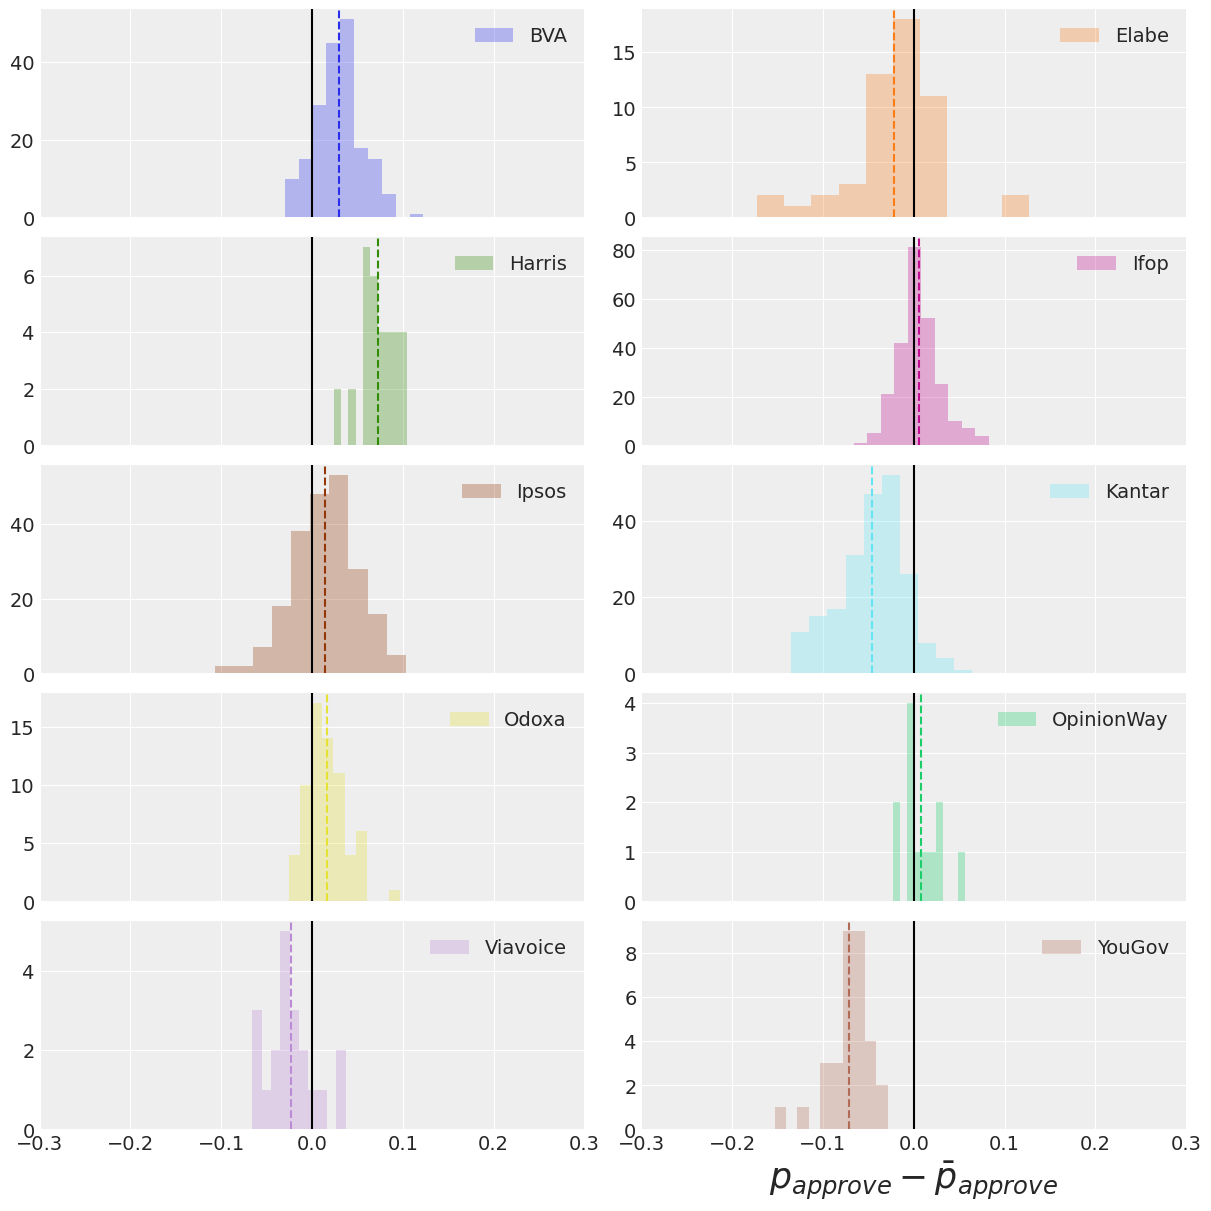

In [27]:
POLLSTER_VALS = {
    pollster: data[data["sondage"] == pollster]["diff_approval"].values
    for pollster in list(POLLSTERS)
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-0.3, 0.3)
    ax.legend()

plt.xlabel(r"$p_{approve} - \bar{p}_{approve}$", fontsize=25);

A positive (resp. negative) bias means the pollster tends to report higher (resp. lower) popularity rates than the average pollster. We'll see what the model has to say about this, but our prior is that, for instance, YouGov and Kantar tend to be below average, while Harris and BVA tend to be higher.

And now for the bias per method:

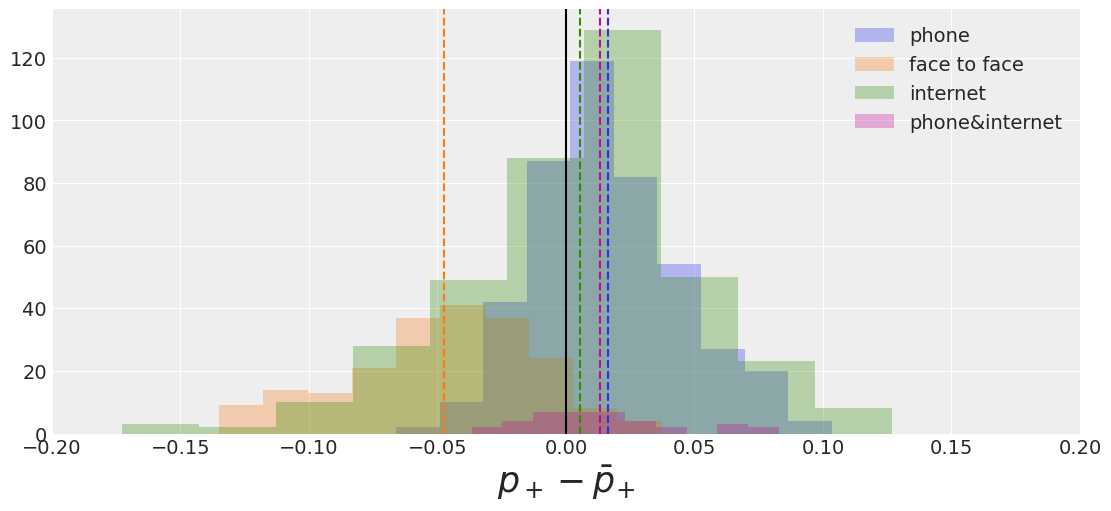

In [28]:
METHOD_VALS = {
    method: data[data["method"] == method]["diff_approval"].values
    for method in list(data["method"].unique())
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-0.2, 0.2)
ax.set_xlabel(r"$p_+ - \bar{p}_{+}$", fontsize=25)
ax.legend();

Face-to-face polls seem to give systematically below-average approval rates, while telephone polls seem to give slightly higher-than-average results.

Again, keep in mind that there is substantial correlation between pollsters and method, so take this with a grain of salt -- that's why it's useful to add that to the model actually: it will be able to decipher these correlations, integrate them into the full data generating process, and report finer estimates of each bias. 

Speaking of models, do you know what time it is? It's model time, of course!!

## Model

Each poll $i$ at month $m$ from the beginning of a president’s term finds that
$y_i$ individuals have a positive opinion of the president’s action over
$n_i$ respondents. We model this as

$$y_{i,m} \sim Binomial(p_{i,m}, n_{i,m})$$

We loosely call $p_{i,m}$ the *popularity* of the president, $m$ month into his
presidency. This is the quantity we would like to model.

Why specify the month when the time information is already contained in the
succession of polls? Because French people tend to be less and less satisfied
with their president as their term moves, regardless of their action.

We model $p_{i,m}$ with a random walk logistic regression:

$$p_{i,m} = logit^{-1}(\mu_m + \alpha_k + \zeta_j)$$

$\mu_m$ is the underlying support for the president at month $m$. $\alpha_k$ is
the bias of the pollster, while $\zeta_j$ is the inherent bias of the polling
method. The biases are assumed to be completely unpooled at first, i.e we model
one bias for each pollster and method:

$$\alpha_k \sim Normal(0, \sigma_k)\qquad \forall pollster k$$

and 

$$\zeta_j \sim Normal(0, \sigma_j)\qquad \forall method j$$

We treat the time variation of $\mu$ with a correlated random walk:

$$\mu_m | \mu_{m-1} \sim Normal(\mu_{m-1}, \sigma_m)$$

For the sake of simplicity, we choose not to account at first for a natural
decline in popularity $\delta$, the unmeployment at month $m$, $U_m$, or
random events that can happen during the term. 

In [21]:
data["num_approve"] = np.floor(data["samplesize"] * data["p_approve"]).astype("int")
data

field_date president sondage  samplesize        method  p_approve  \
0    2002-05-15   chirac2    Ifop         924         phone       0.51   
1    2002-05-20   chirac2  Kantar         972  face to face       0.50   
2    2002-05-23   chirac2     BVA        1054         phone       0.52   
3    2002-05-26   chirac2   Ipsos         907         phone       0.48   
4    2002-06-16   chirac2    Ifop         974         phone       0.49   
...         ...       ...     ...         ...           ...        ...   
1078 2021-03-29    macron  Kantar        1000      internet       0.36   
1079 2021-03-30    macron  YouGov        1068      internet       0.30   
1080 2021-04-07    macron   Elabe        1003      internet       0.33   
1081 2021-04-10    macron   Ipsos        1002      internet       0.37   
1082 2021-04-26    macron  Kantar        1000      internet       0.35   

      p_disapprove  year  month  p_approve_mean  diff_approval  num_approve  
0             0.44  2002      5        0.502500   7.500000e-03          471  
1             0.48  2002      5        0.502500  -2.500000e-03          486  
2             0.37  2002      5        0.502500   1.750000e-02          548  
3             0.48  2002      5        0.502500  -2.250000e-02          435  
4             0.43  2002      6        0.505000  -1.500000e-02          477  
...            ...   ...    ...             ...            ...          ...  
1078          0.58  2021      3        0.375455  -1.545455e-02          360  
1079          0.61  2021      3        0.375455  -7.545455e-02          320  
1080          0.63  2021      4        0.350000  -2.000000e-02          330  
1081          0.58  2021      4        0.350000   2.000000e-02          370  
1082          0.58  2021      4        0.350000   5.551115e-17          350  

[1083 rows x 12 columns]

Each observation is uniquely identified by `(pollster, field_date)`:

In [23]:
pollster_by_method_id, pollster_by_methods = data.set_index(
    ["sondage", "method"]
).index.factorize(sort=True)
month_id = np.hstack(
    [
        pd.Categorical(
            data[data.president == president].field_date.dt.to_period("M")
        ).codes
        for president in data.president.unique()
    ]
)
months = np.arange(max(month_id) + 1)

In [24]:
COORDS = {
    "pollster_by_method": pollster_by_methods,
    "month": months,
    "observation": data.set_index(["sondage", "field_date"]).index,
}

### Fixed `mu` for GRW

In [25]:
with pm.Model(coords=COORDS) as pooled_popularity:

    bias = pm.Normal("bias", 0, 0.15, dims="pollster_by_method")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="month")

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(mu[month_id] + bias[pollster_by_method_id]),
        dims="observation",
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


0, dim: observation, 1083 =? 1083


The acceptance probability does not match the target. It is 0.6805530815011923, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


We plot the posterior distribution of the pollster and method biases:

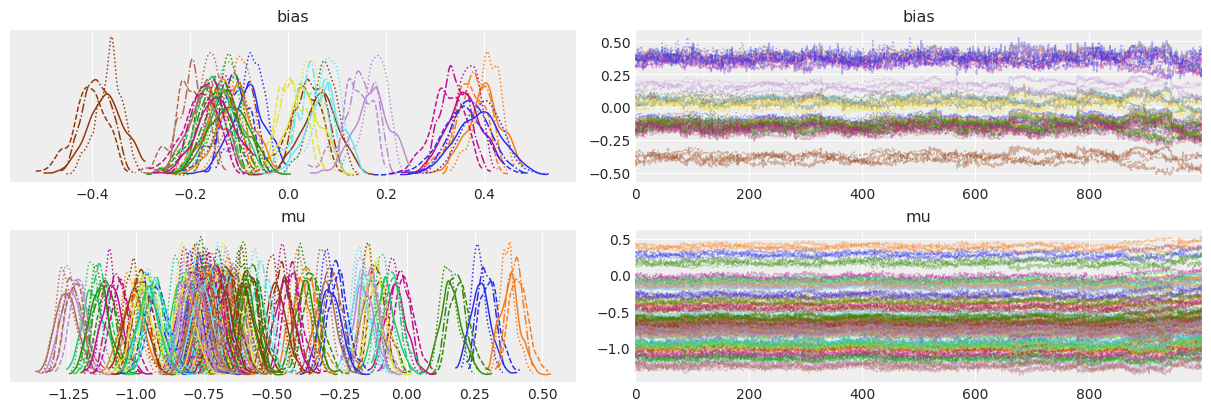

In [26]:
arviz.plot_trace(idata, var_names=["~popularity"], compact=True);

Since we are performing a logistic regression, these coefficients can be tricky to interpret. When the bias is positive, this means that we need to add to the latent popularity to get the observation, which means that the pollster/method tends to be biased towards giving higher popularity scores.

In [27]:
arviz.summary(idata, round_to=2, var_names=["~popularity"])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bias[0] -0.09  0.03   -0.16    -0.03       0.01     0.01     12.55     26.24   
bias[1]  0.39  0.03    0.33     0.45       0.01     0.01     12.49     27.66   
bias[2] -0.14  0.04   -0.20    -0.07       0.01     0.01     12.88     27.73   
bias[3]  0.35  0.04    0.28     0.41       0.01     0.01     13.30     31.16   
bias[4]  0.05  0.04   -0.01     0.12       0.01     0.01     13.22     32.58   
...       ...   ...     ...      ...        ...      ...       ...       ...   
mu[55]  -0.94  0.04   -1.02    -0.86       0.01     0.01     16.85     40.81   
mu[56]  -0.97  0.04   -1.04    -0.89       0.01     0.01     17.02     53.13   
mu[57]  -0.94  0.04   -1.02    -0.87       0.01     0.01     16.41     42.00   
mu[58]  -0.79  0.04   -0.86    -0.72       0.01     0.01     16.58     45.91   
mu[59]  -0.75  0.04   -0.83    -0.68       0.01     0.01     16.68     56.97   

         r_hat  
bias[0]   1.25  
bias[1]   1.25  
bias[2]   1.24  
bias[3]   1.23  
bias[4]   1.23  
...        ...  
mu[55]    1.17  
mu[56]    1.17  
mu[57]    1.18  
mu[58]    1.18  
mu[59]    1.17  

[75 rows x 9 columns]

In [28]:
mean_bias = idata.posterior["bias"].mean(("chain", "draw")).to_dataframe()
mean_bias.round(2)

bias
pollster_by_method_level_0 pollster_by_method_level_1      
BVA                        internet                   -0.09
                           phone                       0.39
Elabe                      internet                   -0.14
Harris                     internet                    0.35
Ifop                       internet                    0.05
                           phone                       0.06
                           phone&internet              0.02
Ipsos                      internet                   -0.15
                           phone                       0.16
Kantar                     face to face               -0.18
                           internet                    0.38
Odoxa                      internet                   -0.12
OpinionWay                 internet                   -0.13
Viavoice                   internet                   -0.16
YouGov                     internet                   -0.38

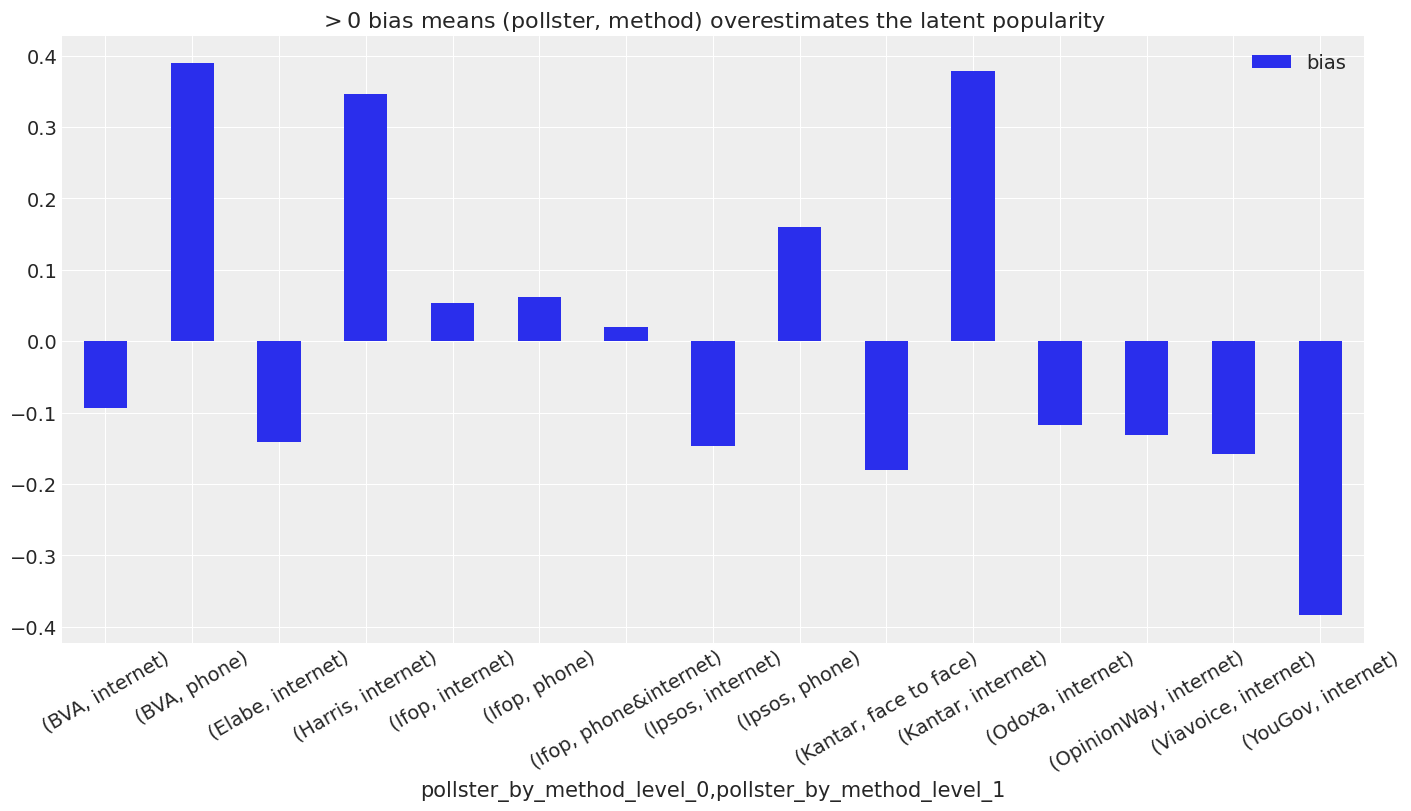

In [29]:
ax = mean_bias.plot.bar(figsize=(14, 8), rot=30)
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");

We now plot the posterior values of `mu`. Since the model is completely pooled, we only have 60 values, which correspond to a full term:

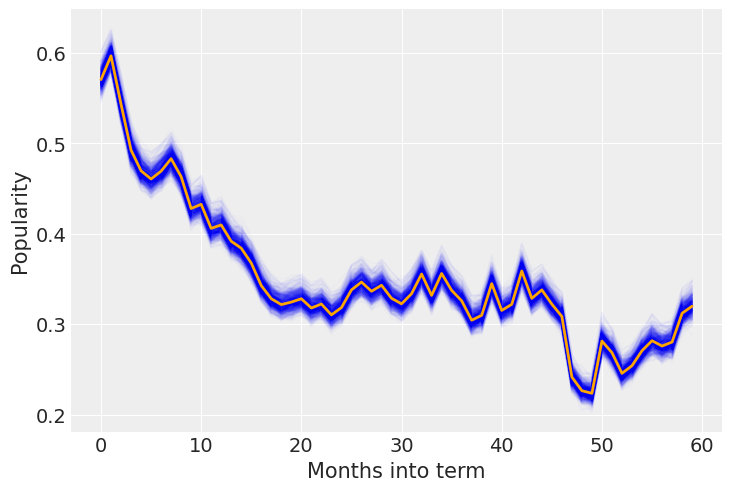

In [30]:
post_pop = logistic(idata.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots()
for i in np.random.choice(post_pop.coords["sample"].size, size=1000):
    ax.plot(
        idata.posterior.coords["month"],
        post_pop.isel(sample=i),
        alpha=0.01,
        color="blue",
    )
post_pop.mean("sample").plot(ax=ax, color="orange", lw=2)
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

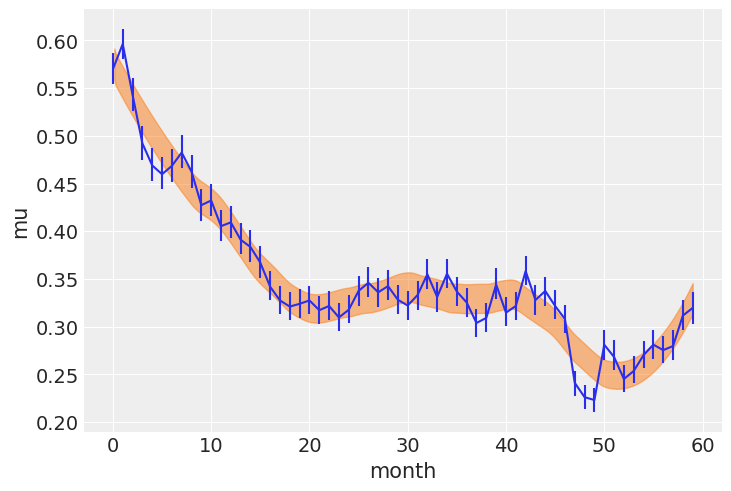

In [31]:
hdi_data = arviz.hdi(logistic(idata.posterior["mu"]))
ax = arviz.plot_hdi(idata.posterior.coords["month"], hdi_data=hdi_data)
ax.vlines(
    idata.posterior.coords["month"],
    hdi_data.sel(hdi="lower")["mu"],
    hdi_data.sel(hdi="higher")["mu"],
)
post_pop.median("sample").plot(ax=ax);

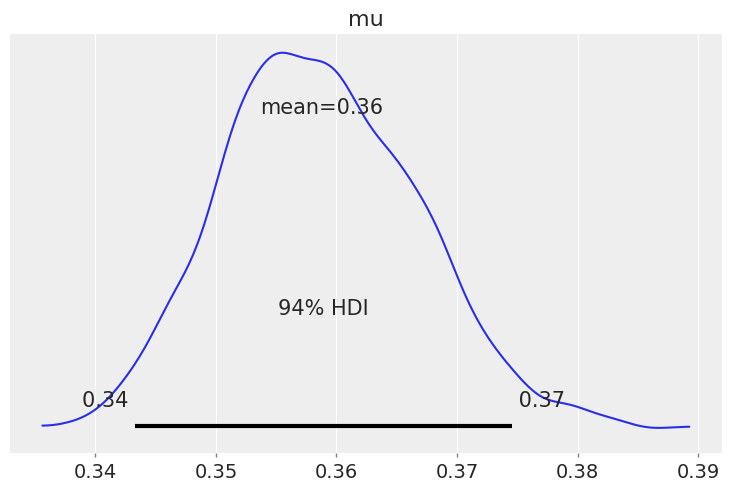

In [32]:
arviz.plot_posterior(logistic(idata.posterior["mu"].sel(month=42)));

### Infer the standard deviation $\sigma$ of the random walk

In [33]:
with pm.Model(coords=COORDS) as pooled_popularity:

    bias = pm.Normal("bias", 0, 0.15, dims="pollster_by_method")
    sigma_mu = pm.HalfNormal("sigma_mu", 0.5)
    mu = pm.GaussianRandomWalk("mu", sigma=sigma_mu, dims="month")

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(mu[month_id] + bias[pollster_by_method_id]),
        dims="observation",
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_mu, bias]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


0, dim: observation, 1083 =? 1083


The acceptance probability does not match the target. It is 0.5785557388752816, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9418662268607951, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9281451022733074, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


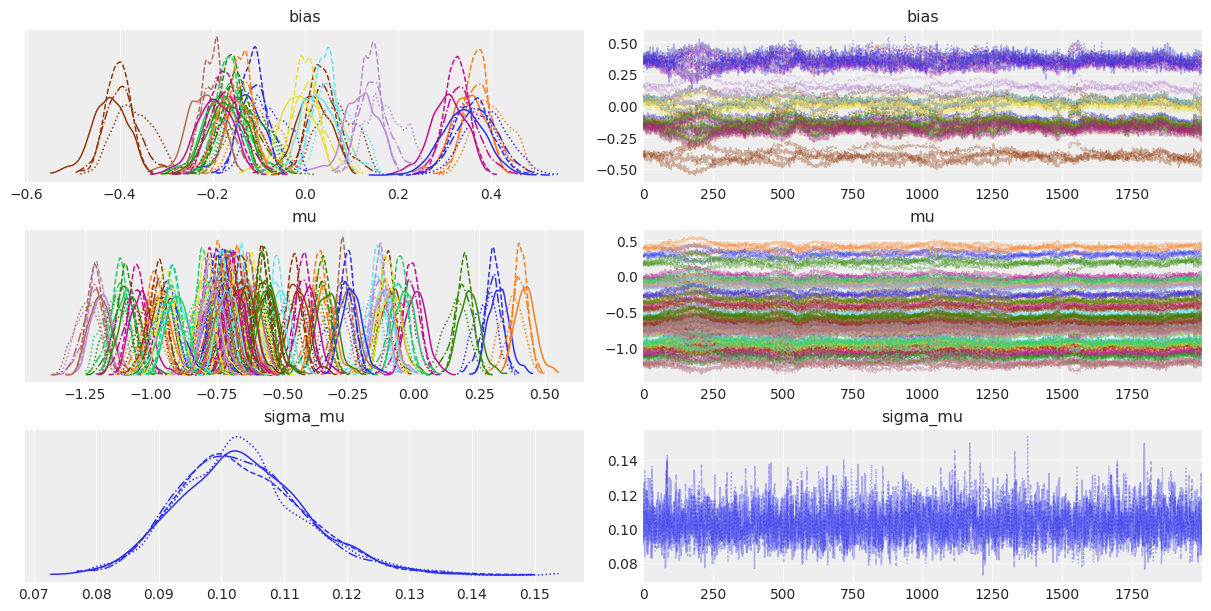

In [34]:
arviz.plot_trace(idata, var_names=["~popularity"], compact=True);

In [35]:
arviz.summary(idata, round_to=2, var_names=["~popularity"])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bias[0]  -0.11  0.04   -0.18    -0.02       0.01     0.01     13.93     46.07   
bias[1]   0.37  0.04    0.30     0.46       0.01     0.01     14.02     42.62   
bias[2]  -0.16  0.04   -0.22    -0.07       0.01     0.01     14.46     46.20   
bias[3]   0.33  0.04    0.26     0.42       0.01     0.01     14.47     38.72   
bias[4]   0.04  0.04   -0.03     0.12       0.01     0.01     15.08     44.30   
...        ...   ...     ...      ...        ...      ...       ...       ...   
mu[56]   -0.95  0.04   -1.04    -0.87       0.01     0.01     16.89     49.26   
mu[57]   -0.92  0.04   -1.01    -0.84       0.01     0.01     16.78     44.81   
mu[58]   -0.78  0.04   -0.87    -0.70       0.01     0.01     16.09     50.04   
mu[59]   -0.74  0.04   -0.83    -0.66       0.01     0.01     17.23     41.49   
sigma_mu  0.10  0.01    0.08     0.12       0.00     0.00   4166.58   4021.90   

          r_hat  
bias[0]    1.21  
bias[1]    1.20  
bias[2]    1.20  
bias[3]    1.19  
bias[4]    1.19  
...         ...  
mu[56]     1.16  
mu[57]     1.16  
mu[58]     1.17  
mu[59]     1.16  
sigma_mu   1.00  

[76 rows x 9 columns]

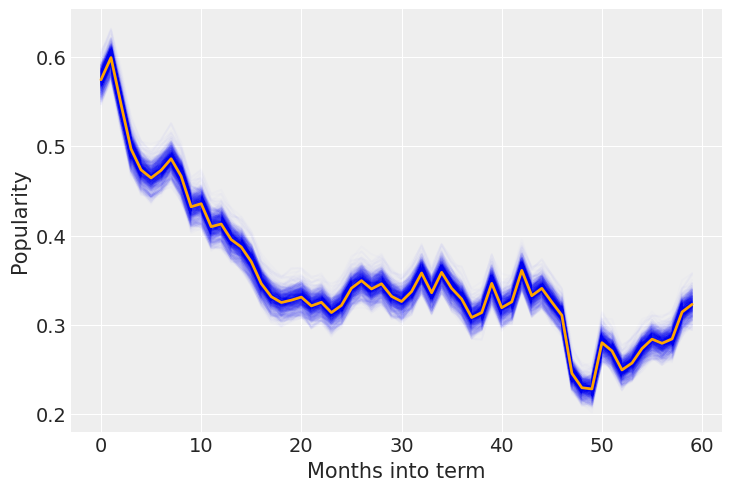

In [36]:
post_pop = logistic(idata.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots()
for i in np.random.choice(post_pop.coords["sample"].size, size=1000):
    ax.plot(
        idata.posterior.coords["month"],
        post_pop.isel(sample=i),
        alpha=0.01,
        color="blue",
    )
post_pop.mean("sample").plot(ax=ax, color="orange", lw=2)
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

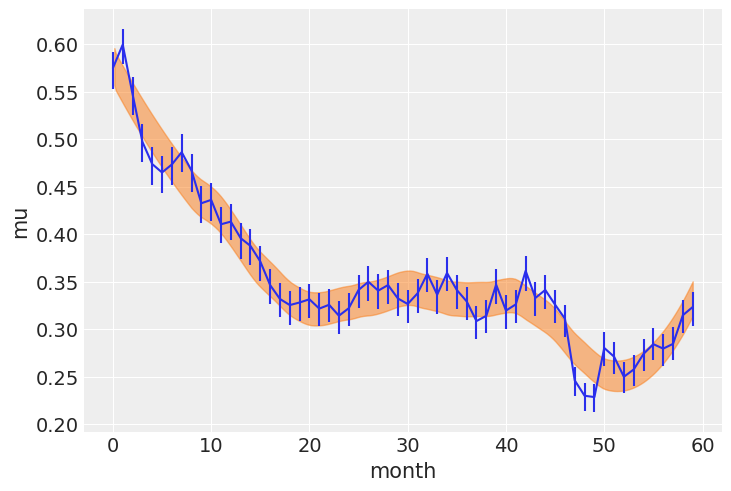

In [37]:
hdi_data = arviz.hdi(logistic(idata.posterior["mu"]))
ax = arviz.plot_hdi(idata.posterior.coords["month"], hdi_data=hdi_data)
ax.vlines(
    idata.posterior.coords["month"],
    hdi_data.sel(hdi="lower")["mu"],
    hdi_data.sel(hdi="higher")["mu"],
)
post_pop.median("sample").plot(ax=ax);

The posterior variance of the values of $\mu$ looks grossly underestimated; between month 40 and 50 presidents have had popularity rates between .2 nd .4 while here the popularity is estimated aournd .21 plus or minus .02 at best. We need to fhix this.

### A model that accounts for the overdispersion of polls

As we saw with the previous model, the variance of $\mu$'s posterior values is grossly underestimated. This suggests that the variance in the obervations is not only due to variations in the mean value, $p_{approve}$. Indeed, there is variance in the results that probably cannot be accounted for by the pollsters' and method's biases and has more something to do with measurement errors, or other factors we did not include.

We use a Beta-Binomial model to add one degree of liberty and allow the variance to be estimated independently from the mean value:

In [38]:
with pm.Model(coords=COORDS) as pooled_popularity:

    bias = pm.Normal("bias", 0, 0.15, dims="pollster_by_method")
    sigma_mu = pm.HalfNormal("sigma_mu", 0.5)
    mu = pm.GaussianRandomWalk("mu", sigma=sigma_mu, dims="month")

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(mu[month_id] + bias[pollster_by_method_id]),
        dims="observation",
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_offset, mu, sigma_mu, bias]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


0, dim: observation, 1083 =? 1083


The number of effective samples is smaller than 10% for some parameters.


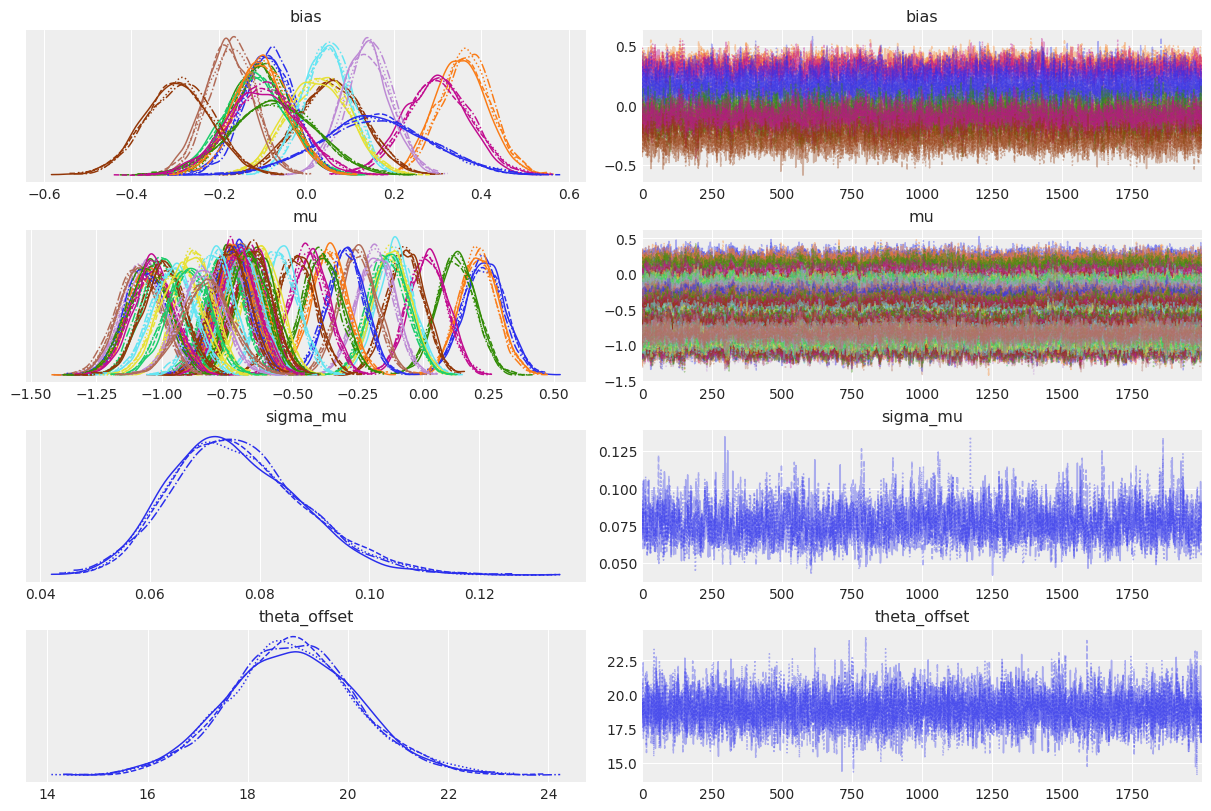

In [39]:
arviz.plot_trace(idata, var_names=["~popularity"], compact=True);

In [40]:
arviz.summary(idata, round_to=2, var_names=["~popularity"])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bias[0]       -0.09  0.06   -0.20     0.03       0.00     0.00    749.33   
bias[1]        0.36  0.06    0.25     0.47       0.00     0.00    737.46   
bias[2]       -0.11  0.07   -0.23     0.02       0.00     0.00    983.45   
bias[3]        0.30  0.07    0.16     0.44       0.00     0.00   1372.94   
bias[4]        0.06  0.08   -0.09     0.20       0.00     0.00   1572.09   
...             ...   ...     ...      ...        ...      ...       ...   
mu[57]        -0.90  0.08   -1.05    -0.74       0.00     0.00   1121.88   
mu[58]        -0.85  0.09   -1.01    -0.69       0.00     0.00   1216.10   
mu[59]        -0.83  0.10   -1.01    -0.65       0.00     0.00   1613.90   
sigma_mu       0.08  0.01    0.05     0.10       0.00     0.00   2103.78   
theta_offset  18.91  1.28   16.42    21.31       0.01     0.01   7399.62   

              ess_tail  r_hat  
bias[0]        1914.16   1.01  
bias[1]        1983.10   1.01  
bias[2]        2532.76   1.00  
bias[3]        2548.57   1.00  
bias[4]        3202.83   1.00  
...                ...    ...  
mu[57]         2565.45   1.00  
mu[58]         2884.34   1.00  
mu[59]         3642.45   1.00  
sigma_mu       3337.56   1.00  
theta_offset   5468.77   1.00  

[77 rows x 9 columns]

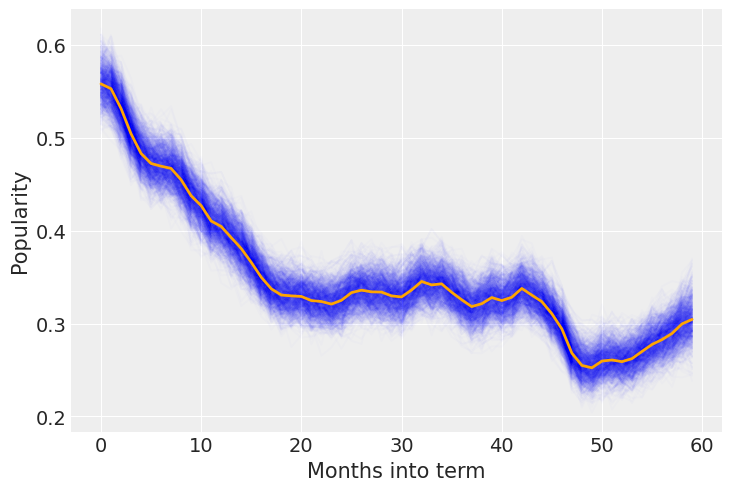

In [41]:
post_pop = logistic(idata.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots()
for i in np.random.choice(post_pop.coords["sample"].size, size=1000):
    ax.plot(
        idata.posterior.coords["month"],
        post_pop.isel(sample=i),
        alpha=0.01,
        color="blue",
    )
post_pop.mean("sample").plot(ax=ax, color="orange", lw=2)
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

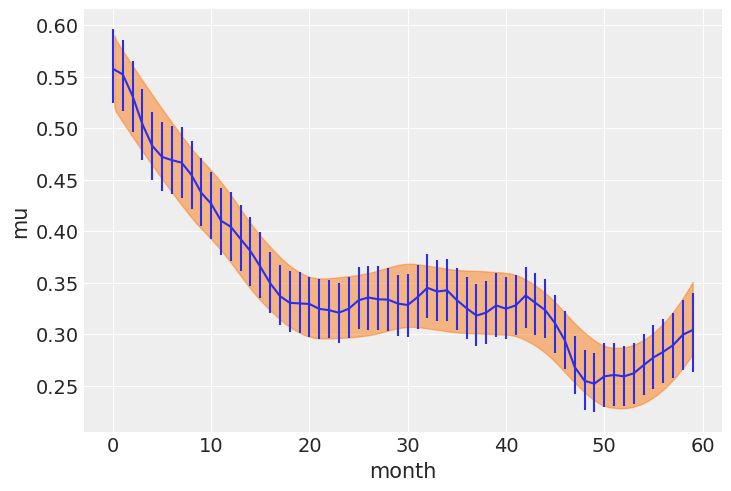

In [42]:
hdi_data = arviz.hdi(logistic(idata.posterior["mu"]))
ax = arviz.plot_hdi(idata.posterior.coords["month"], hdi_data=hdi_data)
ax.vlines(
    idata.posterior.coords["month"],
    hdi_data.sel(hdi="lower")["mu"],
    hdi_data.sel(hdi="higher")["mu"],
)
post_pop.median("sample").plot(ax=ax);

This is much better! It is unlikely we would be able to do much better than this for the unpooled model; maybe by having one dispersion term per term/month. But since we wish to switch to a partially pooled model for $\mu$ we will stop our investigation on the fully pooled model for now.

### Hierarchical model

In [43]:
president_id, presidents = data["president"].factorize(sort=False)
COORDS["president"] = presidents

In [44]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollster_by_method")
    month_effect = pm.Normal("month_effect", 0, 0.15, shape=len(COORDS["month"]) + 1)
    shrinkage_pop = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.GaussianRandomWalk(
        "month_president_effect",
        mu=month_effect,
        sigma=shrinkage_pop,
        dims=("president", "month"),
    )

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(
            month_president_effect[president_id, month_id]
            + house_effect[pollster_by_method_id]
        ),
        dims="observation",
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

In [45]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [month_president_effect, shrinkage_pop, month_effect, house_effect]


/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


RuntimeError: Chain 0 failed.

Mmmh, that doesn't sample because we get zero derivates for some variables... Let's check the model's test point:

In [46]:
hierarchical_popularity.check_test_point()

house_effect                 14.67
month_effect                 59.67
shrinkage_pop_log__          -0.77
month_president_effect     9895.94
N_approve                -83867.83
Name: Log-probability of test_point, dtype: float64

Interesting: the problem doesn't come from a -inf test point or from missing values in the data -- the problem really comes from the model. A safe bet here is to try and reparametrize the model with a non-centered parametrization:

In [47]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollster_by_method")

    month_effect = pm.Normal("month_effect", 0, 0.15, dims="month")
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    raw_rw = pm.GaussianRandomWalk("raw_rw", sigma=1.0, dims=("president", "month"))
    month_president_effect = pm.Deterministic(
        "month_president_effect",
        month_effect + raw_rw * sd,
        dims=("president", "month"),
    )

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(
            month_president_effect[president_id, month_id]
            + house_effect[pollster_by_method_id]
        ),
        dims="observation",
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_rw, shrinkage_pop, month_effect, house_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


0, dim: observation, 1083 =? 1083


The number of effective samples is smaller than 25% for some parameters.


So our sampling problem indeed came from a challenging geometry when the model was parametrized with the centered parametrization. Switching to a non-centered one fixed it. Now, do our estimates make sense?

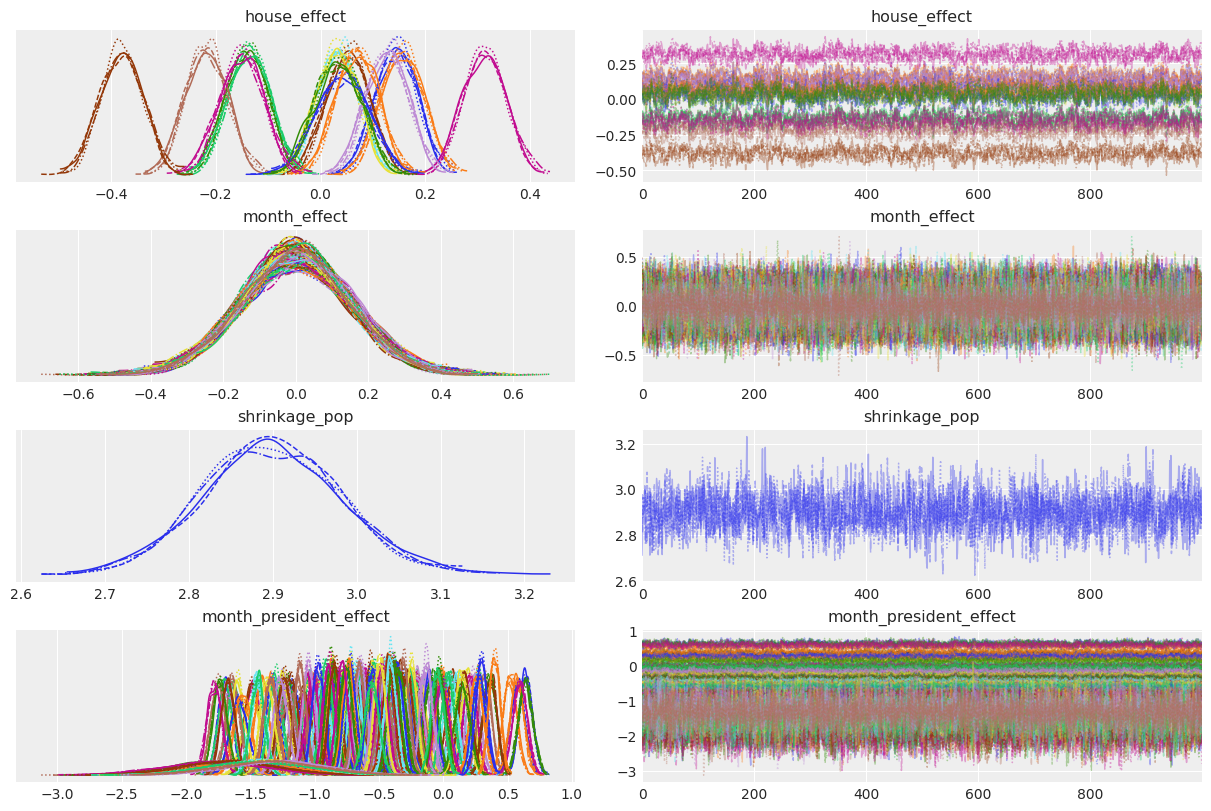

In [48]:
arviz.plot_trace(
    idata,
    var_names=["~popularity", "~rw"],
    filter_vars="regex",
);

That looks a bit weird right? `shrinkage_pop`, the random walk's standard deviation, seems really high! That's basically telling us that the president's popularity can change a lot from one month to another, which we now from domain knowledge is not true. The `month_effect` are all similar and centered on 0, which means all months are very similar -- there can't really be a bad month or a good month. 

This is worrying for at least two reasons: 1) we _know_ from prior knowledge that there _are_ good and bad months for presidents; 2) this extreme similarity in `month_effect` directly contradicts the high `shrinkage_pop`: how can the standard deviation be so high if months are all the same?

So something is missing here. Actually, we should really have an intercept, which represents the baseline presidential approval, no matter the month and president. The tricky thing here is that `pm.GaussianRandomWalk` uses [a distribution to initiate the random walk](https://docs.pymc.io/api/distributions/timeseries.html#pymc3.distributions.timeseries.GaussianRandomWalk). So, if we don't constrain it to zero, we will get an additive non-identifiability -- for each president and month, we'll have two intercepts, `baseline` and the initial value of the random walk. `pm.GaussianRandomWalk` only accepts distribution objects for the `init` kwarg though, so we have to implement the random walk by hand, i.e:

$$\mu_n = \mu_{n - 1} + Z_n, \, with \, Z_n \sim Normal(0, 1) \, and \, \mu_0 = 0$$

In other words, a Gaussian random walk is just a cumulative sum, where we add a sample from a standard Normal at each step ($Z_n$ here, which is called the innovation of the random walk).

Finally, it's probably useful to add a `president_effect`: it's very probable that some presidents are just more popular than others, even when taking into account the cyclical temporal variations.

Let's code that up!

In [49]:
COORDS["month_minus_origin"] = COORDS["month"][1:]

In [50]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = pm.Normal("president_effect", sigma=0.15, dims="president")
    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollster_by_method")

    month_effect = pm.Normal("month_effect", 0, 0.15, dims="month")
    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(
            baseline
            + president_effect[president_id]
            + month_effect[month_id]
            + month_president_effect[president_id, month_id]
            + house_effect[pollster_by_method_id]
        ),
        dims="observation",
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [shrinkage_pop, rw_innovations, month_effect, house_effect, president_effect, baseline]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 307 seconds.


0, dim: observation, 1083 =? 1083


/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/pytho

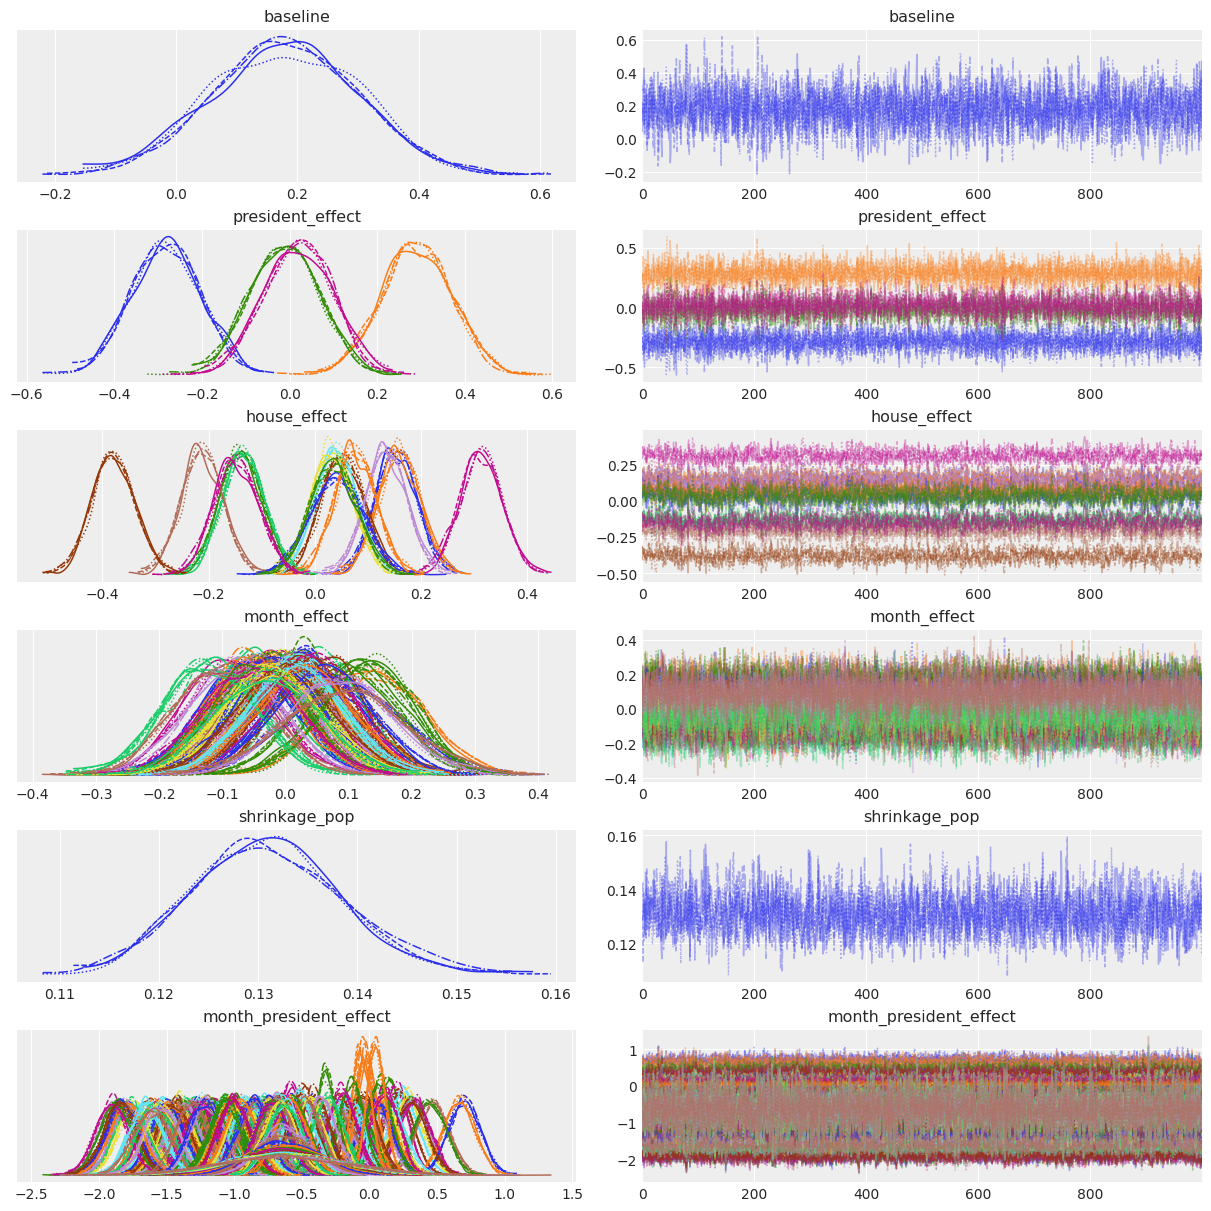

In [51]:
arviz.plot_trace(
    idata,
    var_names=["~popularity", "~rw"],
    filter_vars="regex",
);

That looks much better, doesn't it? Now we do see a difference in the different months, and the shrinkage standard deviation looks much more reasonable too, meaning that once we've accounted for the variation in popularity associated with the other effects, the different presidents' popularity isn't that different on a monthly basis -- i.e there _are_ cycles in popularity, no matter who the president is.

We could stop there, but, for fun, let's improve this model even further by:

1. Use a Beta-Binomial likelihood. We already saw in the completely pooled model that it improves fit and convergence a lot. Plus, it makes scientific sense: for a lot of reasons, each poll probably has a different true Binomial probability than all the other ones -- even when it comes from the same pollster; just think about measurement errors or the way the sample is different each time. Here, we parametrize the Beta-Binomial by its mean and precision, instead of the classical $\alpha$ and $\beta$ parameters. For more details about this distribution and parametrization, see [this blog post](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html#Build-me-a-model).

2. Make sure that our different effects sum to zero. Think about the month effect. It only makes sense in a relative sense: some months are better than average, some other are worse, but you can't have _only_ good months -- they'd be good compared to what? So we want to make sure that the average month effect is 0, while allowing each month to be better or worse than average if needed. To do that, we use a Normal distribution whose dimensions are constrained to sum to zero. In PyMC, we can use the `ZeroSumNormal` distribution, that [Adrian Seyboldt](https://github.com/aseyboldt) contributed and kindly shared with us.

Ok, enough talking, let's code!

In [52]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
    ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

In [66]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster_by_method")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(
            baseline
            president_effect[president_id]
            + month_effect[month_id]
            + month_president_effect[president_id, month_id]
            + house_effect[pollster_by_method_id]
        ),
        dims="observation",
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )
#pm.model_to_graphviz(hierarchical_popularity)

In [67]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_offset, shrinkage_pop, rw_innovations, month_effect_truncated_, house_effect_truncated_, president_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.


0, dim: observation, 1083 =? 1083


/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/remi/.virtualenvs/pollsposition/lib/pytho

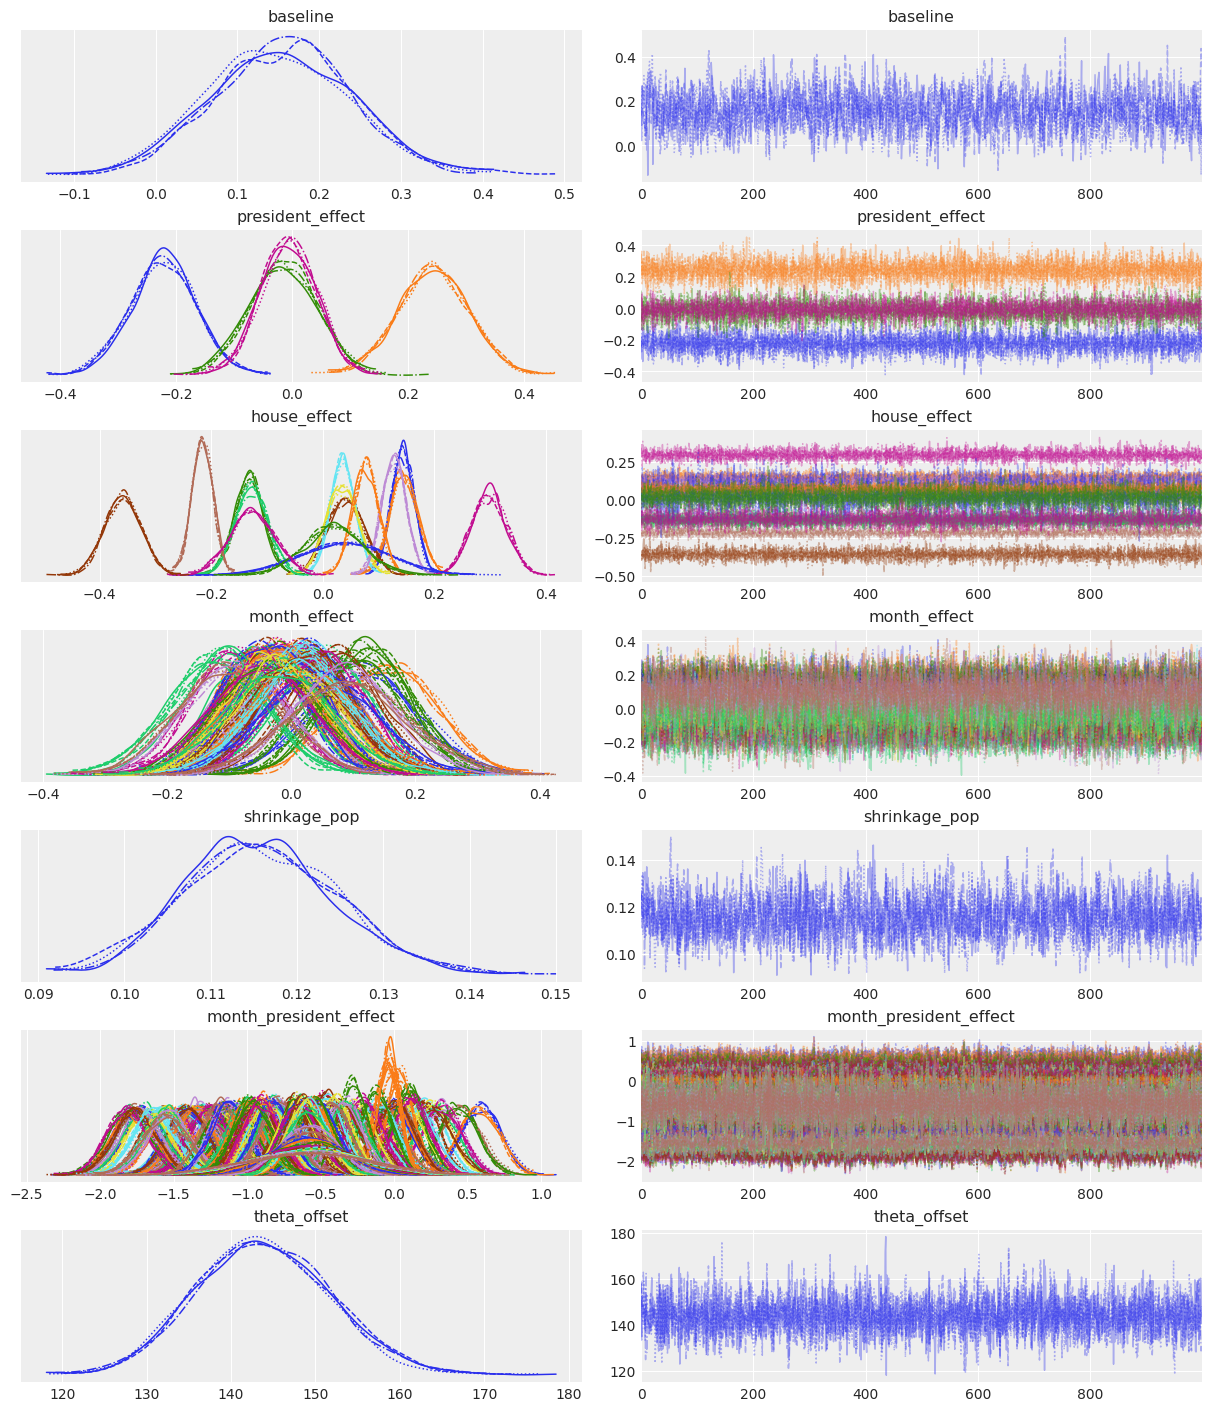

In [56]:
arviz.plot_trace(
    idata,
    var_names=["~popularity", "~truncated", "~rw_innovations"],
    filter_vars="regex",
    compact=True,
);

In [68]:
arviz.summary(
    idata,
    round_to=2,
    var_names=["~popularity", "~truncated", "~rw_innovations"],
    filter_vars="regex",
)

/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean    sd  hdi_3%  hdi_97%  mcse_mean  \
president_effect[0]            -0.15  0.08   -0.31    -0.01       0.00   
president_effect[1]             0.31  0.08    0.16     0.47       0.00   
president_effect[2]             0.05  0.08   -0.09     0.21       0.00   
president_effect[3]             0.07  0.07   -0.06     0.21       0.00   
house_effect[0]                 0.14  0.02    0.11     0.18       0.00   
...                              ...   ...     ...      ...        ...   
month_president_effect[3,56]   -0.49  0.38   -1.18     0.22       0.00   
month_president_effect[3,57]   -0.49  0.39   -1.20     0.26       0.00   
month_president_effect[3,58]   -0.49  0.41   -1.26     0.29       0.01   
month_president_effect[3,59]   -0.49  0.43   -1.31     0.29       0.01   
theta_offset                  143.86  7.82  128.95   158.29       0.11   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
president_effect[0]              0.00   3364.61   3059.12    1.0  
president_effect[1]              0.00   3719.51   2900.94    1.0  
president_effect[2]              0.00   3285.87   3000.76    1.0  
president_effect[3]              0.00   2708.65   2733.02    1.0  
house_effect[0]                  0.00   5099.50   3097.05    1.0  
...                               ...       ...       ...    ...  
month_president_effect[3,56]     0.00   6749.98   2600.16    1.0  
month_president_effect[3,57]     0.00   6491.34   2516.22    1.0  
month_president_effect[3,58]     0.01   6709.37   2620.99    1.0  
month_president_effect[3,59]     0.01   6869.49   2705.24    1.0  
theta_offset                     0.08   5227.57   2741.67    1.0  

[321 rows x 9 columns]

In [69]:
mean_house_effect = (
    idata.posterior["house_effect"].mean(("chain", "draw")).to_dataframe()
)
mean_house_effect.round(2)

house_effect
pollster_by_method_level_0 pollster_by_method_level_1              
BVA                        internet                            0.14
                           phone                               0.15
Elabe                      internet                           -0.13
Harris                     internet                            0.30
Ifop                       internet                            0.04
                           phone                               0.04
                           phone&internet                      0.03
Ipsos                      internet                           -0.13
                           phone                               0.13
Kantar                     face to face                       -0.21
                           internet                            0.03
Odoxa                      internet                            0.08
OpinionWay                 internet                            0.02
Viavoice                   internet                           -0.13
YouGov                     internet                           -0.36

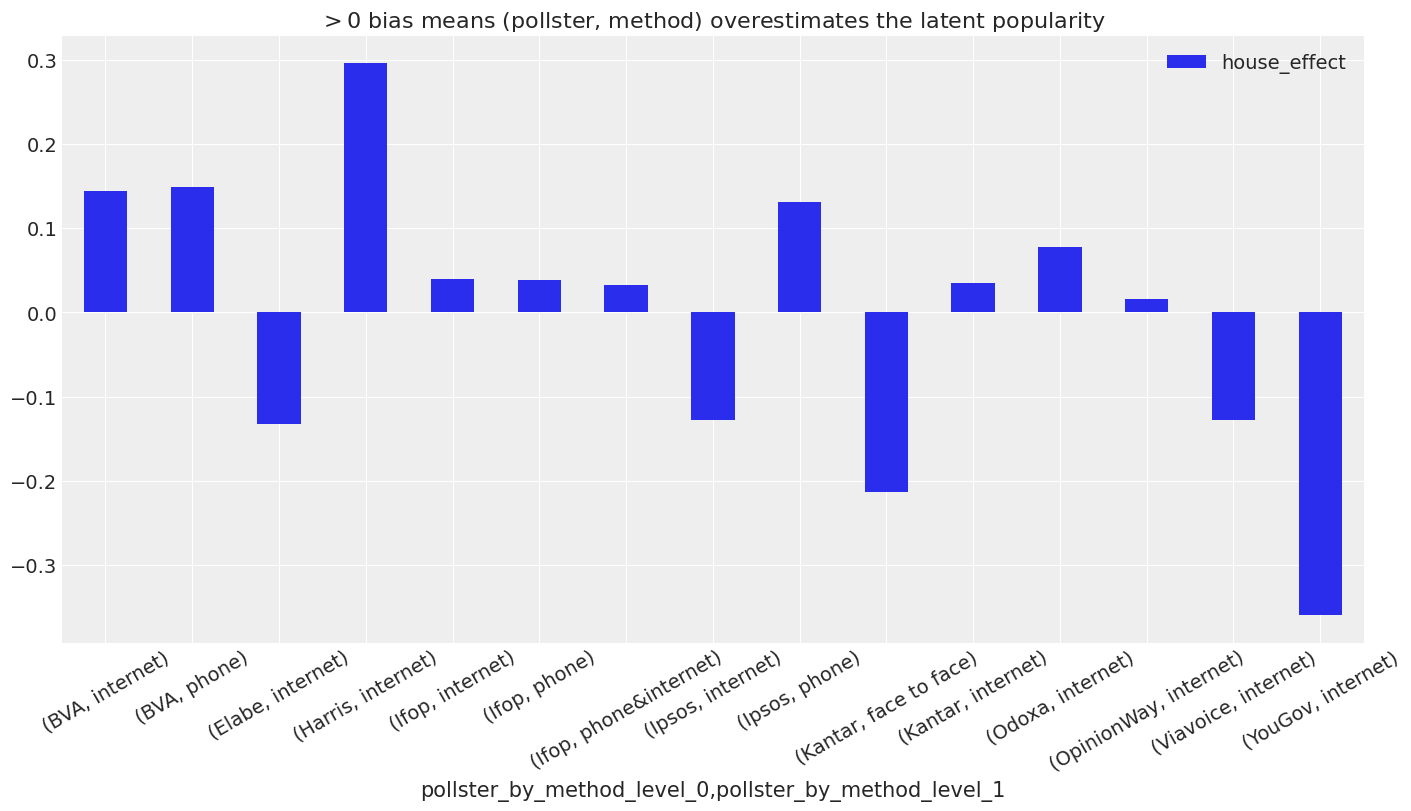

In [70]:
ax = mean_house_effect.plot.bar(figsize=(14, 8), rot=30)
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");

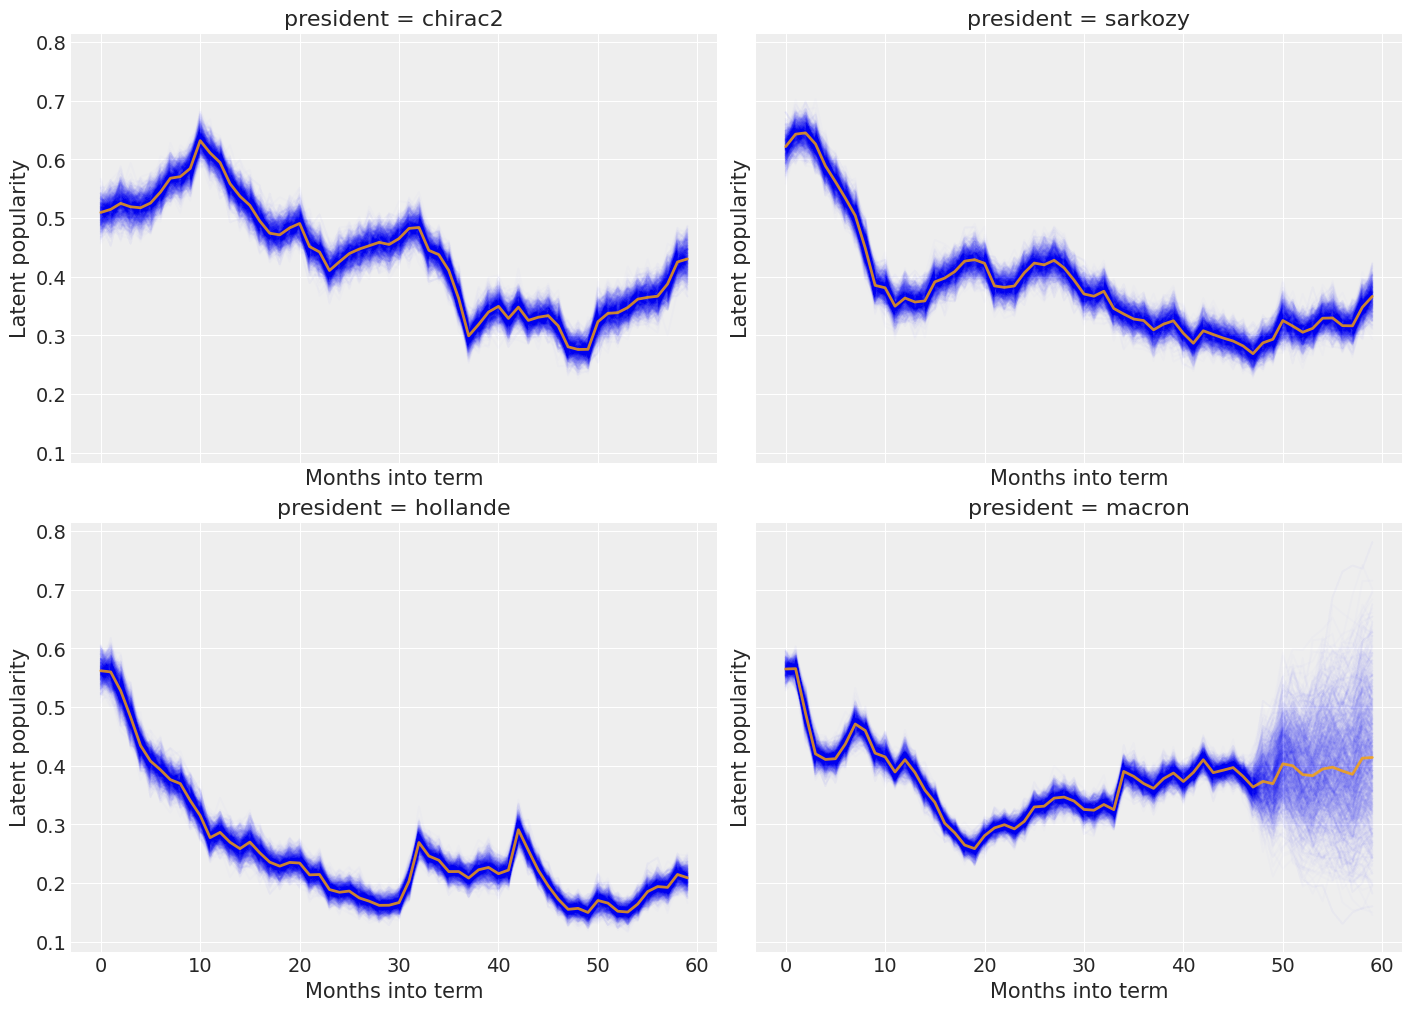

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), idata.posterior.coords["president"]):
    post = idata.posterior.sel(president=p)
    post_pop = logistic(
        (
            #post["baseline"]
            post["president_effect"]
            + post["month_effect"]
            + post["month_president_effect"]
        ).stack(sample=("chain", "draw"))
    )
    post_pop = post_pop.isel(
        sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
    )
    ax.plot(post.coords["month"], post_pop, alpha=0.01, color="blue", label=p)
    post_pop.median("sample").plot(
        ax=ax, color="orange", alpha=0.8, lw=2, label="Median"
    )
    ax.set_ylabel("Latent popularity")
    ax.set_xlabel("Months into term")

In [73]:
with hierarchical_popularity:
    predictives = pm.sample_posterior_predictive(idata)

In [82]:
data['p_approve_predicted'] = np.mean(predictives['N_approve'], axis=0) / data["samplesize"]

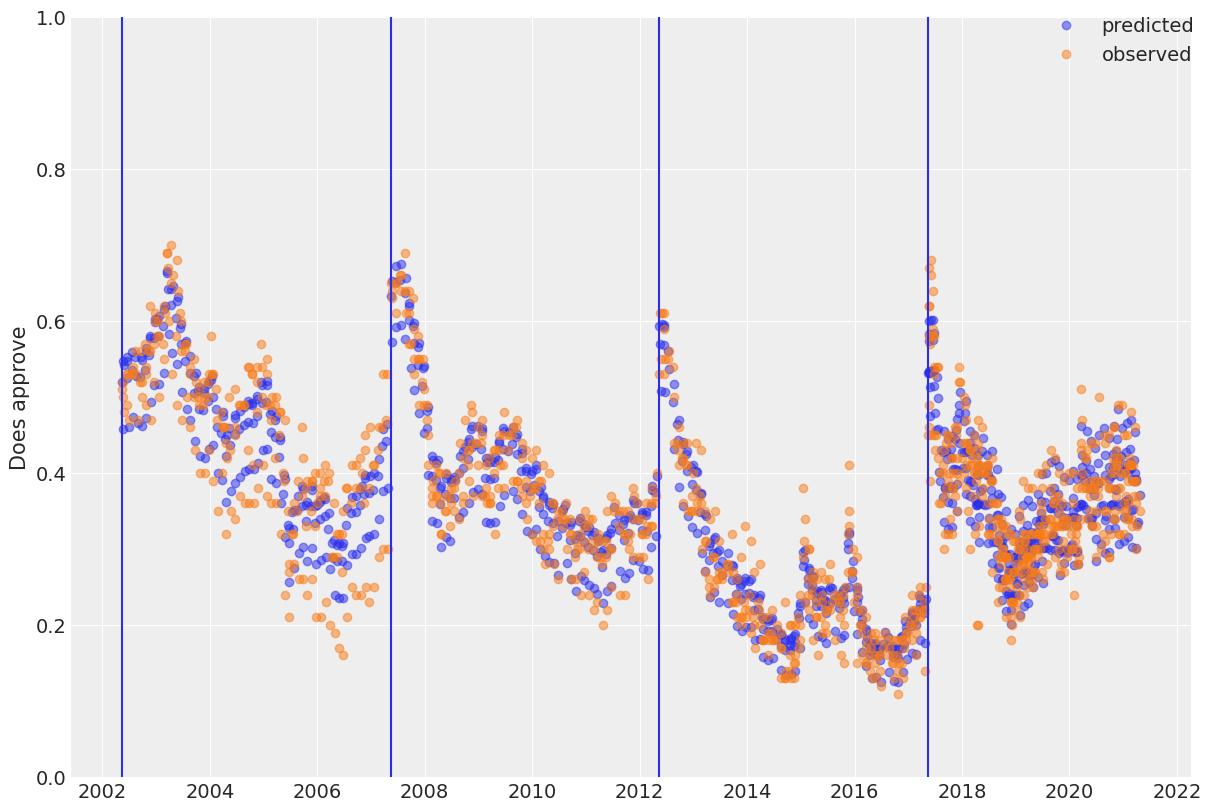

In [92]:
predicted_approval_rates = data["p_approve_predicted"].values
approval_rates = data["p_approve"].values
newterm_dates = data.reset_index().groupby("president").first()["field_date"].values

dates = data.field_date

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dates, predicted_approval_rates, "o", alpha=0.5, label="predicted")
ax.plot(dates, approval_rates, "o", alpha=0.5, label="observed")
ax.set_ylim(0, 1)
ax.set_ylabel("Does approve")
for date in newterm_dates:
    ax.axvline(date)
fig.legend();

## TODO

- Posterior predictive analysis: distribution of $p_{\mathrm{approve}}$ for each pollster and method. We can plot the approval rates for each poll for each president.

- Re-read the paper by Gellman et al. on predicting the US presidential election. We may be able to catch something new given our experience with this first model.

- Estimate `month_effect` with a GRW too? This could be easier for the model to first estimate the temporal dependency only for month, and then do that for each month and president.

- Try a GP for the temporal dependency? This would estimate the _covariation_ between months for free, and also GPs tend to behave better than GRW.

- We do not include time correlations in the model, but it is obvious that there is a *dynamic* in the popularity and the popularity at time $t$ also depends on the popularity at times before the previous months; we could add time correlations.

In [3]:
%load_ext watermark
%watermark -n -u -v -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon May 03 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

matplotlib: 3.4.1
pymc3     : 3.11.2
arviz     : 0.11.2
pandas    : 1.2.4
numpy     : 1.20.2
theano    : 1.1.2

